In [130]:

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import datetime
import math
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Importing the Keras libraries and packages
from keras.models import Sequential  # linear stack of layers
from keras.layers import Dense
from keras.layers import LSTM        # Long Short-Term Memory layer
from keras.layers import Dropout     # simple way to prevent overfitting

In [131]:
# Configuration

SHARE = 'AAPL'
SERVICE = 'fred' #'quandl' #'yahoo'

PREDICTORS = ['High', 'Low', 'Open','Close']  #['High', 'Low', 'Open']   # column names with prices
TARGET = 'Close'

TIMESTEP = 90  # the number of previous days used for prediction

START_DATE = datetime.datetime(2010, 1, 1)  # doesn't work for Kaggle Notebook, train set is used instead 
END_DATE = datetime.datetime(2019, 9, 30)

START_DATE_TO_PREDICT = datetime.datetime(2019, 10, 1)  # doesn't work for Kaggle,test set is used instead
END_DATE_TO_PREDICT = datetime.datetime(2019, 10, 31)

N_EPOCHS = 20


In [132]:
# Download stock price data

# For some reason web.DataReader doesn't work on Kaggle

#df_train = web.DataReader(SHARE, SERVICE, START_DATE, END_DATE)
#df_test = web.DataReader(SHARE, SERVICE, START_DATE_TO_PREDICT, END_DATE_TO_PREDICT)

#df_train = pd.read_csv('/kaggle/input/adaniports/ADANIPORTS.csv')

#df_test = pd.read_csv('/kaggle/input/adaniports/ADANIPORTS.csv')
df_total =  pd.read_csv('/kaggle/input/adaniports/ADANIPORTS.csv')

df_train, df_test = train_test_split(df_total, test_size=0.3, shuffle=False).copy()

In [133]:
df_test.tail()


,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
2988,2019-12-24,ADANIPORTS,EQ,366.90,368.00,372.00,366.00,368.50,368.60,368.88,2948878,1.087779e+14,45244.0,1063340,0.3606
2989,2019-12-26,ADANIPORTS,EQ,368.60,368.80,370.60,362.10,362.10,363.65,366.52,2503435,9.175530e+13,33520.0,774317,0.3093
2990,2019-12-27,ADANIPORTS,EQ,363.65,366.75,367.90,362.80,363.85,363.70,365.19,2146972,7.840569e+13,30299.0,445974,0.2077
2991,2019-12-30,ADANIPORTS,EQ,363.70,371.00,371.00,363.75,366.00,365.95,366.81,4732203,1.735840e+14,45583.0,529147,0.1118
2992,2019-12-31,ADANIPORTS,EQ,365.95,366.00,368.65,364.90,366.20,366.00,366.52,2043206,7.488704e+13,16901.0,816396,0.3996


In [134]:
df_test.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
2095,2016-05-13,ADANIPORTS,EQ,195.15,194.6,200.25,179.40,188.80,188.55,193.31,15272242,2.952351e+14,125916.0,7334006,0.4802
2096,2016-05-16,ADANIPORTS,EQ,188.55,189.0,192.20,183.70,185.55,185.80,186.66,9997240,1.866135e+14,90069.0,6444435,0.6446
2097,2016-05-17,ADANIPORTS,EQ,185.80,186.6,187.35,182.70,182.80,183.25,184.45,7208437,1.329615e+14,63213.0,4982441,0.6912
2098,2016-05-18,ADANIPORTS,EQ,183.25,182.4,185.50,180.55,183.20,183.20,183.05,5909252,1.081665e+14,48273.0,3278248,0.5548
2099,2016-05-19,ADANIPORTS,EQ,183.20,184.5,184.50,169.70,170.90,171.55,177.20,13478073,2.388273e+14,74235.0,7891714,0.5855


In [135]:
df_train = df_train.copy()
df_test = df_test.copy()

if 'Date' in df_train.columns:
    df_train.loc[:, 'Date'] = pd.to_datetime(df_train['Date'])
else:
    print("Error: 'Date' column not found in df_train.")

In [136]:
# Data preprocessing

# Fix for used input files on Kaggle
df_train.loc[:, PREDICTORS + [TARGET]]
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

df_train.set_index('Date', inplace=True)
df_test.set_index('Date', inplace=True)


# Removing irrelevant columns
df_train = df_train[PREDICTORS]
df_test = df_test[PREDICTORS]

In [137]:
# Creating numpy 2-dim array for the training set
# size N x K, where N - number of observations
# K - number of predictors

training_set = df_train.values


In [138]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [139]:
print(df_train.columns)
print(df_test.columns)

Index(['High', 'Low', 'Open', 'Close'], dtype='object')
Index(['High', 'Low', 'Open', 'Close'], dtype='object')


In [140]:
target_col_index = df_train.columns.get_loc(TARGET)


In [141]:
# Creating a data structure with timesteps and 1 output
# X_train - 3-dim array size of N x M x K, where 
# N - number of observations
# M - number of previous days (TIMESTEP)
# K - number of predictors/indicators
 
X_train = []
y_train = []
target_col_index = df_train.columns.get_loc(TARGET)
for i in range(TIMESTEP, len(training_set)):
    X_train.append(training_set_scaled[i-TIMESTEP:i, :])       # X_train - list of Numpy arrays
    y_train.append(training_set_scaled[i, target_col_index])
X_train, y_train = np.array(X_train), np.array(y_train)        # convert list to Numpy array


In [142]:
# Building the RNN


# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer - dense layer 
# classic fully connected neural network layer : each input node is connected to each output node
regressor.add(Dense(units = 1))

# Compiling the RNN
# use MSE instead RMSE (Root Mean Squared Error) because we are more interested in the directions taken by our predictions, rather than the closeness of their values to the real stock price
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = N_EPOCHS, batch_size = 32)



Epoch 1/20
2005/2005 [==============================] - 16s 8ms/step - loss: 0.0062
Epoch 2/20
2005/2005 [==============================] - 13s 7ms/step - loss: 0.0032
Epoch 3/20
2005/2005 [==============================] - 13s 7ms/step - loss: 0.0024
Epoch 4/20
2005/2005 [==============================] - 14s 7ms/step - loss: 0.0025
Epoch 5/20
2005/2005 [==============================] - 13s 7ms/step - loss: 0.0021
Epoch 6/20
2005/2005 [==============================] - 13s 7ms/step - loss: 0.0019
Epoch 7/20
2005/2005 [==============================] - 13s 7ms/step - loss: 0.0018
Epoch 8/20
2005/2005 [==============================] - 13s 6ms/step - loss: 0.0018
Epoch 9/20
2005/2005 [==============================] - 14s 7ms/step - loss: 0.0022
Epoch 10/20
2005/2005 [==============================] - 13s 7ms/step - loss: 0.0016
Epoch 11/20
2005/2005 [==============================] - 13s 7ms/step - loss: 0.0018
Epoch 12/20
2005/2005 [==============================] - 14s 7ms/step - lo

In [143]:
# Extracting real prices
real_stock_price = df_test[TARGET].values

# Preparing input data for making predictions
df_total = df_train.append(df_test)
inputs = df_total[len(df_total) - len(df_test) - TIMESTEP:][PREDICTORS]

inputs = sc.transform(inputs)


X_test = []
for i in range(TIMESTEP, TIMESTEP+len(df_test)):
    X_test.append(inputs[i-TIMESTEP:i, :])
X_test = np.array(X_test)

In [144]:
# Making the predictions

predicted_stock_price = regressor.predict(X_test)

# to perform inverse scaler transformation, at first we need to transform 
# 1-dimensional array with predicted prices to 2-dim array of size N x K, 
# where N = number of observations/predictions. 
# K = number of predictors

temp_matrix = np.zeros((len(predicted_stock_price), len(PREDICTORS)))
temp_matrix[:,target_col_index:target_col_index+1] = predicted_stock_price  # temp_matrix[:,[target_col_index]] = predicted_stock_price    

predicted_stock_price = sc.inverse_transform(temp_matrix)[:,target_col_index]

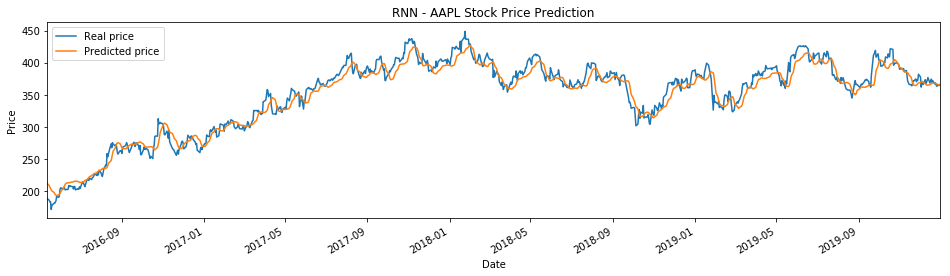

In [145]:
#df_predicted = pd.DataFrame(index=df_test.index)
#df_predicted[TARGET] = predicted_stock_price

df_test['Predicted price'] = predicted_stock_price
df_test[TARGET].plot(figsize=(16,4),legend=True)
df_test['Predicted price'].plot(figsize=(16,4),legend=True)
plt.legend(['Real price', 'Predicted price'])
plt.title('RNN - ' + SHARE + ' Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [146]:
# Evaluating model
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print("The RMSE is {:.3f}.".format(rmse))

The RMSE is 12.792.


In [147]:
# Assuming df_train and df_test are your training and testing DataFrames
print("Training Set:")
print(df_train.head())

print("\nTesting Set:")
print(df_test.head())


Training Set:
               High    Low    Open   Close
Date                                      
2007-11-27  1050.00  770.0  770.00  962.90
2007-11-28   990.00  874.0  984.00  893.90
2007-11-29   914.75  841.0  909.00  884.20
2007-11-30   958.00  890.0  890.00  921.55
2007-12-03   995.00  922.0  939.75  969.30

Testing Set:
              High     Low   Open   Close  Predicted price
Date                                                      
2016-05-13  200.25  179.40  194.6  188.55       212.210484
2016-05-16  192.20  183.70  189.0  185.80       208.645719
2016-05-17  187.35  182.70  186.6  183.25       205.996080
2016-05-18  185.50  180.55  182.4  183.20       203.909814
2016-05-19  184.50  169.70  184.5  171.55       202.108410
